Import required libraries

In [2]:
# !pip install numpy==1.21.0
# !pip install pandas==1.3.5
import pandas as pd
import os
%pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import words
import string
import re
import matplotlib.pyplot as plt
import sys


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/samrawit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/samrawit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/samrawit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /home/samrawit/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/samrawit/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
sys.path.append(os.path.abspath('../scripts'))
from utility import read_csv_file, clean_text, get_sentiment, sentiment_analysis_parallel, plot_articles_trends, calculate_and_plot, plot_day_month, preprocess_dataset, analyze_articles_per_hour, analyze_am_pm_distribution, analyze_topics_with_bertopic, analyze_email_domains, perform_topic_modeling, plot_sentiment, plot_articles_per_day, plot_articles_per_year, plot_monthly_trend, plot_daily_trend, plot_monthly_article_trends, plot_top_publishers_pie_chart, plot_top_headlines_bar_chart

[nltk_data] Downloading package words to /home/samrawit/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/samrawit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/samrawit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/samrawit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Read dataset

In [4]:
all_data_path = '../data/raw_analyst_ratings.csv'
text_data = read_csv_file(all_data_path)

In [5]:
text_data = text_data.get("data")
text_data.head()

,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [6]:
text_data = preprocess_dataset(text_data, 'date')


In [7]:
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 12 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   headline     1407328 non-null  object        
 1   url          1407328 non-null  object        
 2   publisher    1407328 non-null  object        
 3   stock        1407328 non-null  object        
 4   Date         1407328 non-null  datetime64[ns]
 5   time         1407328 non-null  object        
 6   hour         1407328 non-null  int32         
 7   minute       1407328 non-null  int32         
 8   year         1407328 non-null  int32         
 9   month        1407328 non-null  int32         
 10  day          1407328 non-null  int32         
 11  day_of_week  1407328 non-null  object        
dtypes: datetime64[ns](1), int32(5), object(6)
memory usage: 102.0+ MB


In [8]:

path = "../data/yfinance_data/"

# List of dataset file paths
dataset_files = ["AAPL_historical_data.csv", "AMZN_historical_data.csv", "GOOG_historical_data.csv", "META_historical_data.csv", "MSFT_historical_data.csv", "NVDA_historical_data.csv", "TSLA_historical_data.csv"]  # Add your dataset filenames here

# Corresponding variable names for each dataset
dataset_vars = ["AAPL", "AMZN", "GOOG", "META", "MSFT", "NVDA", "TSLA"]

# Dictionary to store processed DataFrames
processed_data = {}

# Loop through each dataset
for file_name, var_name in zip(dataset_files, dataset_vars):
    # Load the dataset
    try:
        print(f"Processing {path + file_name}...")
        df = read_csv_file(path + file_name)

        df = df.get("data")
        
        # Parse the Date column
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        
        # Drop rows with invalid or missing Date
        df.dropna(subset=['Date'], inplace=True)
        
        # Select relevant columns
        selected_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        missing_columns = [col for col in selected_columns if col not in df.columns]
        
        if missing_columns:
            print(f"Warning: {file_name} is missing columns: {missing_columns}")
            continue  # Skip this dataset
        
        df = df[selected_columns]
        
        # Dynamically assign the DataFrame to a variable
        globals()[var_name] = df
        
        # Store the processed DataFrame in the dictionary for additional access
        processed_data[var_name] = df
        
        # Display the first 5 rows
        print(f"First 5 rows of {var_name}:")
        print(df.head())
    except Exception as e:
        print(f"An error occurred while processing {file_name}: {e}")




Processing ../data/yfinance_data/AAPL_historical_data.csv...
First 5 rows of AAPL:
        Date      Open      High       Low     Close  Adj Close     Volume
0 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600
1 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800
2 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000
3 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600
4 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600
Processing ../data/yfinance_data/AMZN_historical_data.csv...
First 5 rows of AMZN:
        Date      Open      High       Low     Close  Adj Close      Volume
0 1997-05-15  0.121875  0.125000  0.096354  0.097917   0.097917  1443120000
1 1997-05-16  0.098438  0.098958  0.085417  0.086458   0.086458   294000000
2 1997-05-19  0.088021  0.088542  0.081250  0.085417   0.085417   122136000
3 1997-05-20  0.086458  0.087500  0.081771  0.081771   0.081771   109344000
4 19

Analysis

In [38]:
articles_per_day_avg, articles_per_year_avg = calculate_and_plot(text_data)

Average Articles Published Per Day of the Week (Monday to Sunday):
day_of_week
Monday       265164
Tuesday      296470
Wednesday    300940
Thursday     302595
Friday       217892
Saturday       7753
Sunday        16514
dtype: int64

Average Articles Published Per Year:
year
2009     11489
2010     81319
2011    131322
2012    122655
2013    121523
2014    134859
2015    135295
2016    141892
2017    124456
2018    146924
2019    150380
2020    105214
dtype: int64


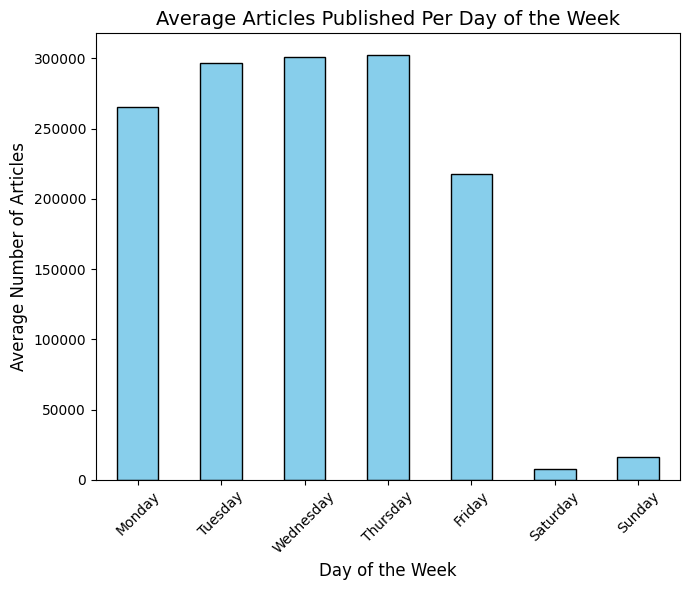

In [39]:
plot_articles_per_day(articles_per_day_avg)

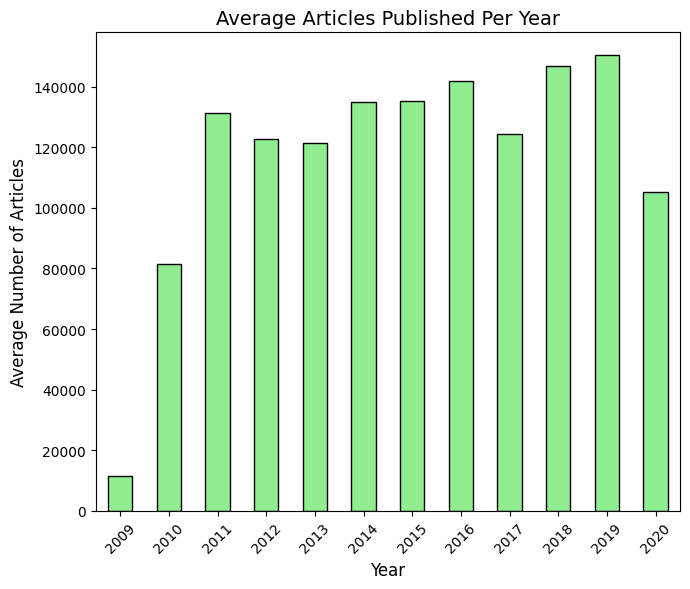

In [40]:
plot_articles_per_year(articles_per_year_avg)

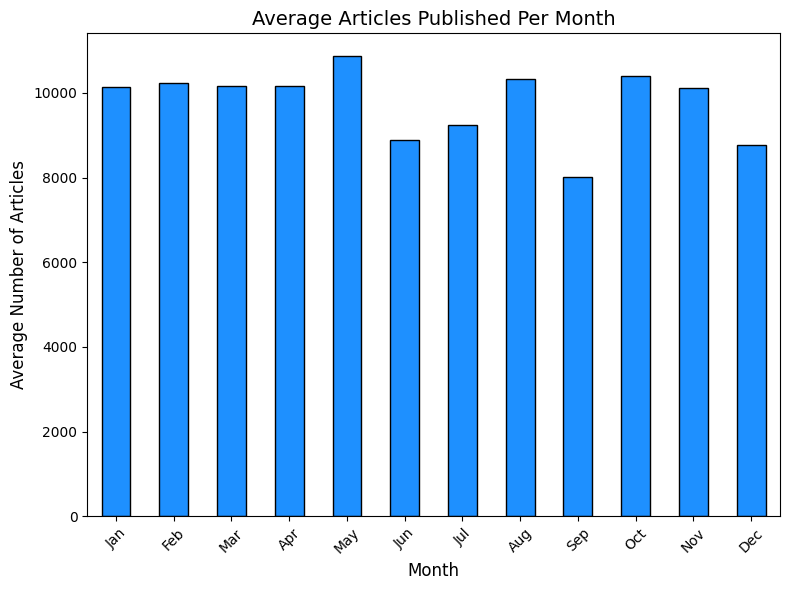

In [41]:
plot_monthly_trend(text_data)

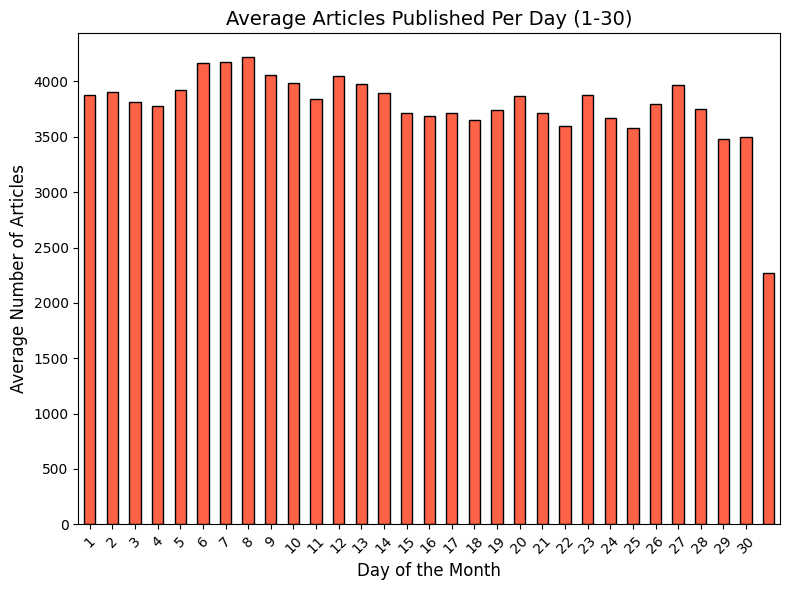

In [42]:
plot_daily_trend(text_data)

Articles Published Per Hour:
hour
0     1351408
1          14
2          57
3          93
4        1469
5        1829
6        2476
7        5033
8        5527
9        5965
10       7669
11       5701
12       5732
13       2710
14       2075
15       1612
16       3939
17       2800
18        704
19        227
20        131
21         82
22         48
23         27
Name: count, dtype: int64


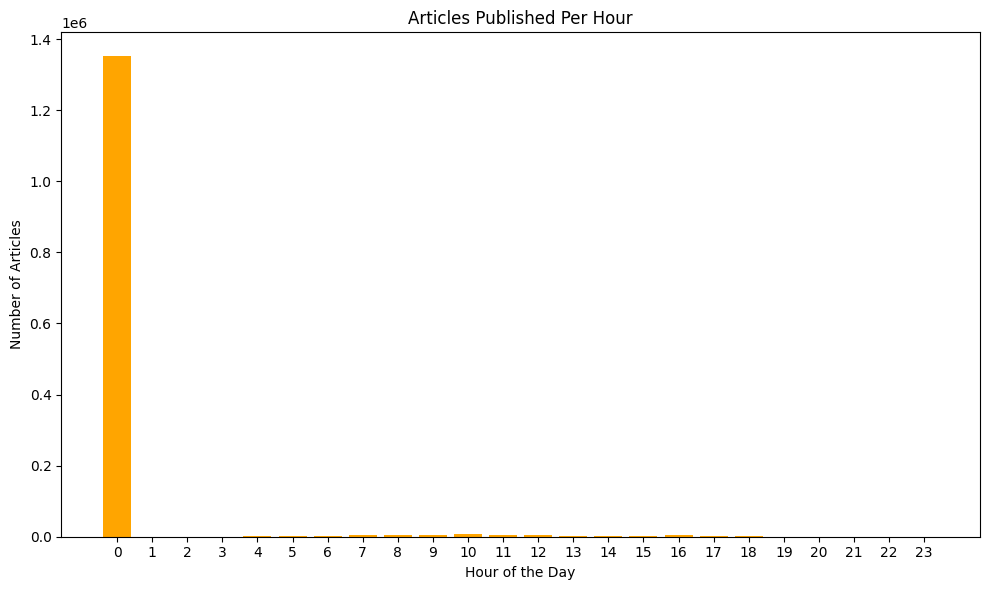

In [43]:
articles_per_hour = analyze_articles_per_hour(text_data)

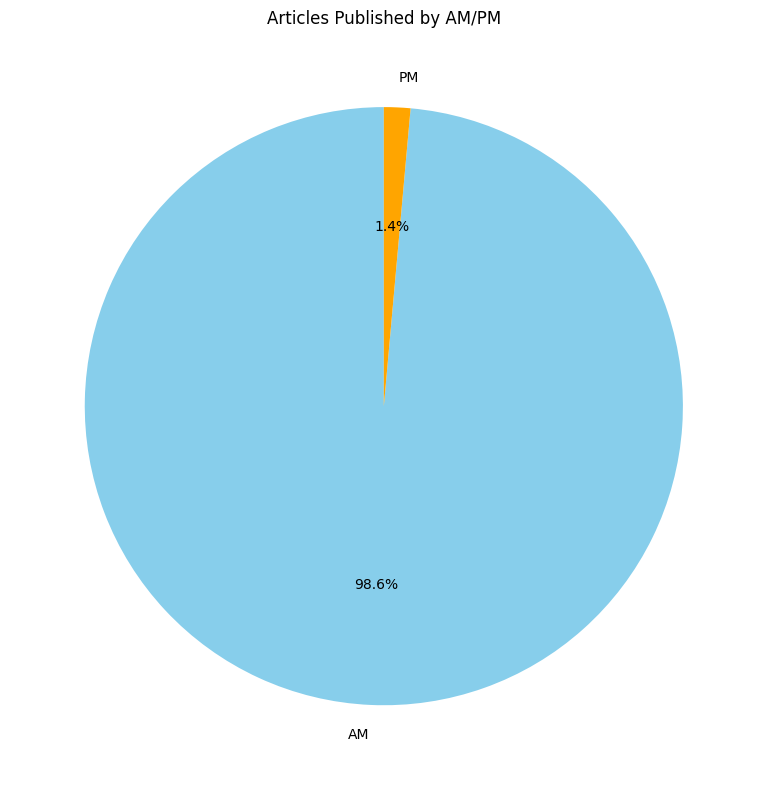

AM Articles: 1387241
PM Articles: 20087


{'AM': 1387241, 'PM': 20087}

In [44]:
analyze_am_pm_distribution(articles_per_hour)


In [15]:
%pip install nbformat>=4.2.0

Note: you may need to restart the kernel to use updated packages.


In [9]:
text_data['headlineClean'] = text_data['headline'].apply(clean_text)

text_data[['headline', 'headlineClean']]

,headline,headlineClean
0,Stocks That Hit 52-Week Highs On Friday,stock hit week
1,Stocks That Hit 52-Week Highs On Wednesday,stock hit week
2,71 Biggest Movers From Friday,biggest
3,46 Stocks Moving In Friday's Mid-Day Session,stock moving midday session
4,B of A Securities Maintains Neutral on Agilent...,neutral price target
...,...,...
1407323,Top Narrow Based Indexes For August 29,top narrow based august
1407324,Recap: Wednesday's Top Percentage Gainers and ...,recap top percentage
1407325,UPDATE: Oppenheimer Color on China Zenix Auto ...,update color china auto initiation
1407326,Oppenheimer Initiates China Zenix At Outperfor...,china outperform


In [46]:
analyze_topics_with_bertopic(text_data, 'headlineClean')


Top 10 Topics:
   Topic  Count                                     Name  \
0     -1    247                  -1_news_loss_oil_update   
1      0     41            0_trading_several_higher_amid   
2      1     41                1_target_price_buy_rating   
3      2     38              2_watch_activity_solar_call   
4      3     34      3_earnings_preview_quarter_previous   
5      4     33             4_neutral_analyst_tech_chief   
6      5     32                    5_hit_week_stock_post   
7      6     31                   6_hold_bank_money_fast   
8      7     30  7_update_market_midmorning_midafternoon   
9      8     30                   8_top_looking_bal_swan   

                                      Representation  \
0  [news, loss, oil, update, hearing, outlook, ac...   
1  [trading, several, higher, amid, lower, compan...   
2  [target, price, buy, rating, coverage, brown, ...   
3  [watch, activity, solar, call, huge, may, stoc...   
4  [earnings, preview, quarter, previous, se

{'topic_info':     Topic  Count                                     Name  \
 0      -1    247                  -1_news_loss_oil_update   
 1       0     41            0_trading_several_higher_amid   
 2       1     41                1_target_price_buy_rating   
 3       2     38              2_watch_activity_solar_call   
 4       3     34      3_earnings_preview_quarter_previous   
 5       4     33             4_neutral_analyst_tech_chief   
 6       5     32                    5_hit_week_stock_post   
 7       6     31                   6_hold_bank_money_fast   
 8       7     30  7_update_market_midmorning_midafternoon   
 9       8     30                   8_top_looking_bal_swan   
 10      9     30              9_agreement_merger_bid_case   
 11     10     30        10_morgan_overweight_target_price   
 12     11     28           11_coverage_phase_diabetes_peg   
 13     12     28                 12_like_dang_almost_dont   
 14     13     26             13_moving_session_stock_mo

8 total unique email domains
Top domains:
publisher_domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64


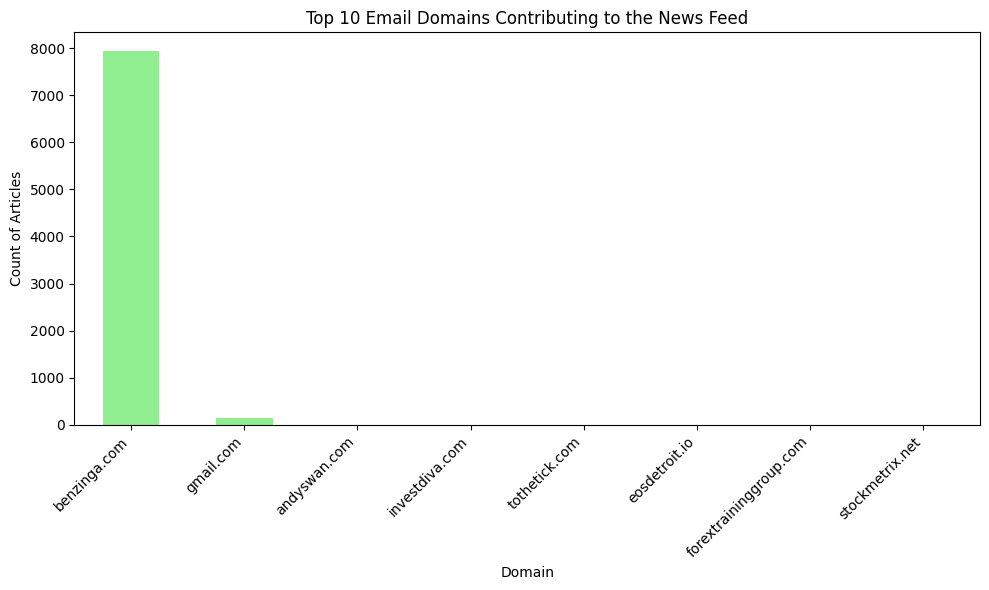

publisher_domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64

In [47]:
analyze_email_domains(text_data, 'publisher')


Identified Topics:
Topic 1: trading, stock, notable, disclosed, outlook, today, research, lower, technology, common
Topic 2: earnings, market, buy, update, higher, company, coverage, trading, yoy, morning
Topic 3: revenue, estimate, share, year, neutral, corporation, update, dividend, following, beat
Topic 4: price, target, update, morgan, outperform, bank, biggest, option, hold, alert
Topic 5: stock, week, session, moving, new, hit, set, industry, high, midday


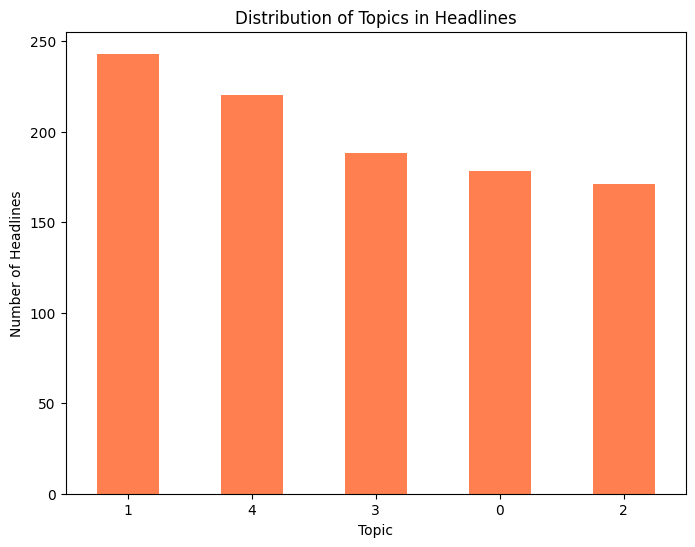

Results saved to 'headline_topics.csv'


(                                                  headline  \
 1201723  Syntel, Inc. Reports Q1 EPS of $1.11 vs $1.03 ...   
 1282616  Mid-Day Market Update: K2M Group Rises On Acqu...   
 554075   Aramchol's Failed Past Isn't Its Future; Galme...   
 1190332     60 Stocks Moving In Thursday's Mid-Day Session   
 192958   Anheuser-Busch shares are trading lower after ...   
 ...                                                    ...   
 65227    Jefferies Initiates Altera Corporation At Buy,...   
 1355282            4 'Tariff-Proof' Stock Picks From A Pro   
 745258                   Benzinga's Top #PreMarket Gainers   
 1211394  Earnings Preview: Analysts Expect Crown Castle...   
 517562   First Solar Reports Q4 GAAP EPS $1.89 May Not ...   
 
                                                        url  \
 1201723  https://www.benzinga.com/news/earnings/13/04/3...   
 1282616  https://www.benzinga.com/news/18/08/12285391/m...   
 554075   https://www.benzinga.com/analyst-ratings/an

In [48]:
perform_topic_modeling(text_data, 'headlineClean')

Get APPLE companies stock dataset

In [12]:
# Access the AAPL dataset
aapl_df = processed_data["AAPL"]

# Display the first 5 rows of the AAPL dataset
aapl_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098943,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093781,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086898,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089049,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091630,73449600


In [14]:
aapl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10998 entries, 0 to 10997
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10998 non-null  datetime64[ns]
 1   Open       10998 non-null  float64       
 2   High       10998 non-null  float64       
 3   Low        10998 non-null  float64       
 4   Close      10998 non-null  float64       
 5   Adj Close  10998 non-null  float64       
 6   Volume     10998 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 601.6 KB


In [15]:
aapl_df['Date'] = pd.to_datetime(aapl_df['Date'], errors='coerce')

# Set 'Date' as the index
aapl_df.set_index('Date', inplace=True)

In [16]:
aapl_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.098943,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093781,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086898,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089049,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091630,73449600


In [17]:
# Ensure 'Date' column is in datetime format
text_data['Date'] = pd.to_datetime(text_data['Date'], errors='coerce')

# Set 'Date' as the index
text_data.set_index('Date', inplace=True)

Merge AAPL with rating dataset

In [18]:
aapl_merged_data = pd.merge(text_data, aapl_df, left_on='Date', right_index=True, how='inner')


In [19]:
aapl_merged_data.head()

,headline,url,publisher,stock,time,hour,minute,year,month,day,day_of_week,headlineClean,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,
2020-06-05,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,A,10:30:54,10,30,2020,6,5,Friday,stock hit week,80.837502,82.937500,80.807503,82.875000,80.843407,137250400
2020-06-03,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,A,10:45:20,10,45,2020,6,3,Wednesday,stock hit week,81.165001,81.550003,80.574997,81.279999,79.287506,104491200
2020-05-26,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,A,04:30:07,4,30,2020,5,26,Tuesday,biggest,80.875000,81.059998,79.125000,79.182503,77.241432,125522000
2020-05-22,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,A,12:45:06,12,45,2020,5,22,Friday,stock moving midday session,78.942497,79.807503,78.837502,79.722504,77.768188,81803200
2020-05-22,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,A,11:38:59,11,38,2020,5,22,Friday,neutral price target,78.942497,79.807503,78.837502,79.722504,77.768188,81803200


In [20]:
# Filter rows where 'headline' contains "AAPL"
aapl_related_data = aapl_merged_data[aapl_merged_data['headline'].str.contains("AAPL", case=False, na=False)]

# Display the filtered DataFrame
aapl_related_data

,headline,url,publisher,stock,time,hour,minute,year,month,day,day_of_week,headlineClean,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,
2009-08-27,China Unicom(CHU) to Launch Apple (AAPL) Iphone,https://www.benzinga.com/benzingastaff1/2009/8...,BenzingaStaff1,A,00:00:00,0,0,2009,8,27,Thursday,china launch apple,6.026786,6.056071,5.886786,6.051786,5.110583,449181600
2011-06-23,At Least We Still Have Apple (AAPL),https://www.benzinga.com/11/06/1204120/at-leas...,Kevin McElroy,AA,00:00:00,0,0,2011,6,23,Thursday,least still apple,11.390714,11.846071,11.361429,11.829643,9.989842,559759200
2011-01-11,"Tuesday's Mid-Day Options Volume Leaders (BAC,...",https://www.benzinga.com/options/11/01/770225/...,Michael J. Zerinskas,AA,00:00:00,0,0,2011,1,11,Tuesday,midday volume bac,12.317143,12.320000,12.123929,12.201429,10.303806,444108000
2011-01-10,"Monday's Mid-Day Options Volume Leaders (C, AA...",https://www.benzinga.com/options/11/01/766490/...,Michael J. Zerinskas,AA,00:00:00,0,0,2011,1,10,Monday,midday volume bac,12.101071,12.258214,12.041786,12.230357,10.328234,448560000
2011-01-07,Earnings For The S&P 500 Expected To Be Highes...,https://www.benzinga.com/news/11/01/761590/ear...,Roger Nachman,AA,00:00:00,0,0,2011,1,7,Friday,earnings highest cat dow,11.928214,12.012500,11.853571,12.004286,10.137321,311931200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-02-03,"Mad Money Lightning Round: Jim Prefers MRK, SY...",https://www.benzinga.com/media/cnbc/109830/mad...,Monica Gerson,ZMH,00:00:00,0,0,2010,2,3,Wednesday,mad money lightning round mot,6.970357,7.150000,6.943571,7.115357,6.008742,615328000
2014-04-24,"ETF Outlook for Thursday, April 24, 2014 (XLK,...",https://www.benzinga.com/etfs/sector-etfs/14/0...,Matthew McCall,ZNGA,00:00:00,0,0,2014,4,24,Thursday,outlook,20.293215,20.357143,20.026072,20.277500,17.815914,759911600
2012-05-29,Stocks to Watch for the All Things Digital Con...,https://www.benzinga.com/trading-ideas/long-id...,Alex Shek,ZNGA,00:00:00,0,0,2012,5,29,Tuesday,stock watch digital conference,20.389286,20.500000,20.189644,20.438213,17.259563,380508800


In [21]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [27]:
sentiment_analysis_parallel(aapl_related_data, 'headlineClean')

[('neutral', 0.0), ('negative', -0.3), ('neutral', 0.0), ('neutral', 0.0), ('neutral', 0.0)]


,headline,url,publisher,stock,time,hour,minute,year,month,day,day_of_week,headlineClean,Open,High,Low,Close,Adj Close,Volume,sentiment,polarity
Date,,,,,,,,,,,,,,,,,,,,
2009-08-27,China Unicom(CHU) to Launch Apple (AAPL) Iphone,https://www.benzinga.com/benzingastaff1/2009/8...,BenzingaStaff1,A,00:00:00,0,0,2009,8,27,Thursday,china launch apple,6.026786,6.056071,5.886786,6.051786,5.110583,449181600,neutral,0.0000
2011-06-23,At Least We Still Have Apple (AAPL),https://www.benzinga.com/11/06/1204120/at-leas...,Kevin McElroy,AA,00:00:00,0,0,2011,6,23,Thursday,least still apple,11.390714,11.846071,11.361429,11.829643,9.989842,559759200,negative,-0.3000
2011-01-11,"Tuesday's Mid-Day Options Volume Leaders (BAC,...",https://www.benzinga.com/options/11/01/770225/...,Michael J. Zerinskas,AA,00:00:00,0,0,2011,1,11,Tuesday,midday volume bac,12.317143,12.320000,12.123929,12.201429,10.303806,444108000,neutral,0.0000
2011-01-10,"Monday's Mid-Day Options Volume Leaders (C, AA...",https://www.benzinga.com/options/11/01/766490/...,Michael J. Zerinskas,AA,00:00:00,0,0,2011,1,10,Monday,midday volume bac,12.101071,12.258214,12.041786,12.230357,10.328234,448560000,neutral,0.0000
2011-01-07,Earnings For The S&P 500 Expected To Be Highes...,https://www.benzinga.com/news/11/01/761590/ear...,Roger Nachman,AA,00:00:00,0,0,2011,1,7,Friday,earnings highest cat dow,11.928214,12.012500,11.853571,12.004286,10.137321,311931200,neutral,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-02-03,"Mad Money Lightning Round: Jim Prefers MRK, SY...",https://www.benzinga.com/media/cnbc/109830/mad...,Monica Gerson,ZMH,00:00:00,0,0,2010,2,3,Wednesday,mad money lightning round mot,6.970357,7.150000,6.943571,7.115357,6.008742,615328000,negative,-0.4125
2014-04-24,"ETF Outlook for Thursday, April 24, 2014 (XLK,...",https://www.benzinga.com/etfs/sector-etfs/14/0...,Matthew McCall,ZNGA,00:00:00,0,0,2014,4,24,Thursday,outlook,20.293215,20.357143,20.026072,20.277500,17.815914,759911600,neutral,0.0000
2012-05-29,Stocks to Watch for the All Things Digital Con...,https://www.benzinga.com/trading-ideas/long-id...,Alex Shek,ZNGA,00:00:00,0,0,2012,5,29,Tuesday,stock watch digital conference,20.389286,20.500000,20.189644,20.438213,17.259563,380508800,neutral,0.0000


In [60]:
sentiment_counts = aapl_related_data['sentiment'].value_counts()

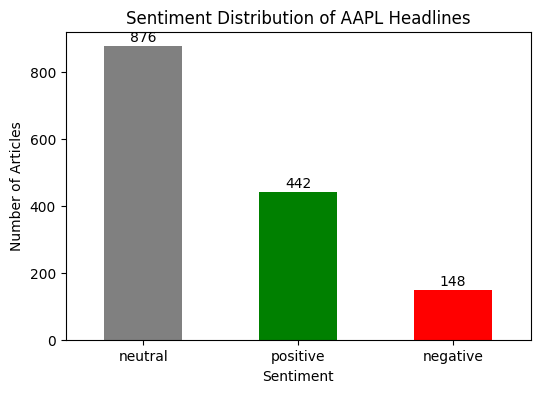

In [61]:
plot_sentiment(sentiment_counts, "AAPL ")

Get AMAZON companies stock dataset

In [62]:
# Access the AMZN dataset
amzn_df = processed_data["AMZN"]

# Display the first 5 rows of the AMZN dataset
amzn_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [35]:
amzn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6846 entries, 0 to 6845
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6846 non-null   datetime64[ns]
 1   Open       6846 non-null   float64       
 2   High       6846 non-null   float64       
 3   Low        6846 non-null   float64       
 4   Close      6846 non-null   float64       
 5   Adj Close  6846 non-null   float64       
 6   Volume     6846 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 374.5 KB


In [63]:
amzn_df['Date'] = pd.to_datetime(amzn_df['Date'], errors='coerce')

# Set 'Date' as the index
amzn_df.set_index('Date', inplace=True)

In [64]:
amzn_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


Merge AMZN with rating dataset

In [65]:
amzn_merged_data = pd.merge(text_data, amzn_df, left_on='Date', right_index=True, how='inner')


In [39]:
amzn_merged_data.head()

,headline,url,publisher,stock,time,hour,minute,year,month,day,day_of_week,headlineClean,publisher_domain,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,,
2020-06-05,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,A,10:30:54,10,30,2020,6,5,Friday,stock hit week,None,122.225502,124.432503,121.856499,124.150002,124.150002,66128000
2020-06-03,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,A,10:45:20,10,45,2020,6,3,Wednesday,stock hit week,None,123.400497,124.400002,123.058502,123.919998,123.919998,53420000
2020-05-26,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,A,04:30:07,4,30,2020,5,26,Tuesday,biggest,None,122.900002,123.099998,120.703003,121.093002,121.093002,71364000
2020-05-22,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,A,12:45:06,12,45,2020,5,22,Friday,stock moving midday session,None,122.750504,123.492500,121.506500,121.844002,121.844002,57342000
2020-05-22,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,A,11:38:59,11,38,2020,5,22,Friday,neutral price target,None,122.750504,123.492500,121.506500,121.844002,121.844002,57342000


In [66]:
# Filter rows where 'headline' contains "AMZN"
amzn_related_data = amzn_merged_data[amzn_merged_data['headline'].str.contains("AMZN", case=False, na=False)]

# Display the filtered DataFrame
amzn_related_data

,headline,url,publisher,stock,time,hour,minute,year,month,day,day_of_week,headlineClean,publisher_domain,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,,
2009-12-21,Holiday Party May Be Starting As Alcoa Inc (NY...,https://www.benzinga.com/general/69244/holiday...,inthemoneystocks,AA,00:00:00,0,0,2009,12,21,Monday,holiday party may starting jump,None,6.524000,6.660000,6.509500,6.639500,6.639500,189472000
2009-10-07,"Fast Money Guys Like RTP, LAZ, AMZN, DFS",https://www.benzinga.com/media/cnbc/21872/fast...,Craig Jones,AA,00:00:00,0,0,2009,10,7,Wednesday,fast money like,None,4.575000,4.724000,4.557500,4.698500,4.698500,148902000
2017-10-26,DrugChannels' Adam Fein Recently Tweets 'Scoop...,https://www.benzinga.com/news/17/10/10235843/d...,Paul Quintaro,ABC,00:00:00,0,0,2017,10,26,Thursday,recently scoop licensed wholesale drug distrib...,None,49.016499,49.145000,48.427502,48.621498,48.621498,112374000
2017-06-08,Amazon (AMZN) to Come Up with New Facility in ...,https://www.benzinga.com/17/06/9583775/amazon-...,Zacks,ABTL,00:00:00,0,0,2017,6,8,Thursday,come new facility,None,50.603001,50.680500,50.305500,50.513500,50.513500,55358000
2009-12-30,US Markets Shed Gains For The Second Consecuti...,https://www.benzinga.com/market-update/73668/u...,Monica Gerson,ABX,00:00:00,0,0,2009,12,30,Wednesday,shed gain second consecutive day,None,6.920000,6.920000,6.764000,6.824500,6.824500,138264000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-05-02,CEOWORLD Top Stocks Picks to Watch 5/2/11- DAN...,https://www.benzinga.com/11/05/1047825/ceoworl...,CEO World,YRCW,00:00:00,0,0,2011,5,2,Monday,top stock watch dang,None,9.828500,10.171000,9.809000,10.059500,10.059500,187962000
2011-04-28,"Stocks we are watching on 4/28- AMZN, LVLT, NF...",https://www.benzinga.com/11/04/1040457/stocks-...,CEO World,YRCW,00:00:00,0,0,2011,4,28,Thursday,stock watching pot ire,None,9.798000,9.839500,9.613500,9.753500,9.753500,146000000
2011-04-26,CEOWORLD Stocks Picks to Watch on 4/26/11 – NF...,https://www.benzinga.com/11/04/1032387/ceoworl...,CEO World,YRCW,00:00:00,0,0,2011,4,26,Tuesday,stock watch pot,None,9.313500,9.321000,9.037000,9.115000,9.115000,224000000


In [67]:
sentiment_analysis_parallel(amzn_related_data, 'headlineClean')

[('neutral', 0.0), ('positive', 0.2), ('neutral', 0.0), ('positive', 0.13636363636363635), ('neutral', 0.0)]


,headline,url,publisher,stock,time,hour,minute,year,month,day,...,headlineClean,publisher_domain,Open,High,Low,Close,Adj Close,Volume,sentiment,polarity
Date,,,,,,,,,,,,,,,,,,,,,
2009-12-21,Holiday Party May Be Starting As Alcoa Inc (NY...,https://www.benzinga.com/general/69244/holiday...,inthemoneystocks,AA,00:00:00,0,0,2009,12,21,...,holiday party may starting jump,None,6.524000,6.660000,6.509500,6.639500,6.639500,189472000,neutral,0.000000
2009-10-07,"Fast Money Guys Like RTP, LAZ, AMZN, DFS",https://www.benzinga.com/media/cnbc/21872/fast...,Craig Jones,AA,00:00:00,0,0,2009,10,7,...,fast money like,None,4.575000,4.724000,4.557500,4.698500,4.698500,148902000,positive,0.200000
2017-10-26,DrugChannels' Adam Fein Recently Tweets 'Scoop...,https://www.benzinga.com/news/17/10/10235843/d...,Paul Quintaro,ABC,00:00:00,0,0,2017,10,26,...,recently scoop licensed wholesale drug distrib...,None,49.016499,49.145000,48.427502,48.621498,48.621498,112374000,neutral,0.000000
2017-06-08,Amazon (AMZN) to Come Up with New Facility in ...,https://www.benzinga.com/17/06/9583775/amazon-...,Zacks,ABTL,00:00:00,0,0,2017,6,8,...,come new facility,None,50.603001,50.680500,50.305500,50.513500,50.513500,55358000,positive,0.136364
2009-12-30,US Markets Shed Gains For The Second Consecuti...,https://www.benzinga.com/market-update/73668/u...,Monica Gerson,ABX,00:00:00,0,0,2009,12,30,...,shed gain second consecutive day,None,6.920000,6.920000,6.764000,6.824500,6.824500,138264000,neutral,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-05-02,CEOWORLD Top Stocks Picks to Watch 5/2/11- DAN...,https://www.benzinga.com/11/05/1047825/ceoworl...,CEO World,YRCW,00:00:00,0,0,2011,5,2,...,top stock watch dang,None,9.828500,10.171000,9.809000,10.059500,10.059500,187962000,positive,0.500000
2011-04-28,"Stocks we are watching on 4/28- AMZN, LVLT, NF...",https://www.benzinga.com/11/04/1040457/stocks-...,CEO World,YRCW,00:00:00,0,0,2011,4,28,...,stock watching pot ire,None,9.798000,9.839500,9.613500,9.753500,9.753500,146000000,neutral,0.000000
2011-04-26,CEOWORLD Stocks Picks to Watch on 4/26/11 – NF...,https://www.benzinga.com/11/04/1032387/ceoworl...,CEO World,YRCW,00:00:00,0,0,2011,4,26,...,stock watch pot,None,9.313500,9.321000,9.037000,9.115000,9.115000,224000000,neutral,0.000000


In [68]:
sentiment_counts = amzn_related_data['sentiment'].value_counts()

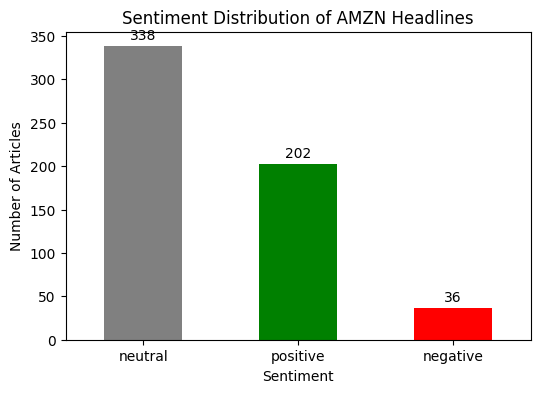

In [69]:
plot_sentiment(sentiment_counts, 'AMZN ')

Get GOOGLE companies stock dataset

In [70]:
# Access the GOOG dataset
goog_df = processed_data["GOOG"]

# Display the first 5 rows of the GOOG dataset
goog_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.496292,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.694573,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.721690,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.608991,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.637103,184645512


In [ ]:
goog_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5020 non-null   datetime64[ns]
 1   Open       5020 non-null   float64       
 2   High       5020 non-null   float64       
 3   Low        5020 non-null   float64       
 4   Close      5020 non-null   float64       
 5   Adj Close  5020 non-null   float64       
 6   Volume     5020 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 274.7 KB


In [71]:
goog_df['Date'] = pd.to_datetime(goog_df['Date'], errors='coerce')

# Set 'Date' as the index
goog_df.set_index('Date', inplace=True)

In [47]:
goog_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.496292,897427216
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.694573,458857488
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.721690,366857939
2004-08-24,2.770615,2.779581,2.579581,2.611960,2.608991,306396159
2004-08-25,2.614201,2.689918,2.587302,2.640104,2.637103,184645512


Merge GOOG with rating dataset

In [72]:
goog_merged_data = pd.merge(text_data, goog_df, left_on='Date', right_index=True, how='inner')

In [49]:
goog_merged_data.head()

,headline,url,publisher,stock,time,hour,minute,year,month,day,day_of_week,headlineClean,publisher_domain,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,,
2020-06-05,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,A,10:30:54,10,30,2020,6,5,Friday,stock hit week,None,70.658501,72.252502,70.300003,71.919502,71.837753,34698000
2020-06-03,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,A,10:45:20,10,45,2020,6,3,Wednesday,stock hit week,None,71.915001,72.327599,71.488853,71.819000,71.737366,25124000
2020-05-26,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,A,04:30:07,4,30,2020,5,26,Tuesday,biggest,None,71.863503,72.050003,70.606499,70.850998,70.770462,41212000
2020-05-22,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,A,12:45:06,12,45,2020,5,22,Friday,stock moving midday session,None,69.835503,70.638000,69.591499,70.521004,70.440842,26188000
2020-05-22,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,A,11:38:59,11,38,2020,5,22,Friday,neutral price target,None,69.835503,70.638000,69.591499,70.521004,70.440842,26188000


In [73]:
# Filter rows where 'headline' contains "GOOG"
goog_related_data = goog_merged_data[goog_merged_data['headline'].str.contains("GOOG", case=False, na=False)]

# Display the filtered DataFrame
goog_related_data

,headline,url,publisher,stock,time,hour,minute,year,month,day,day_of_week,headlineClean,publisher_domain,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,,
2010-02-17,The Google Buzz Guide for the Enterprise (with...,https://www.benzinga.com/146954/the-google-buz...,Mark Fidelman,A,00:00:00,0,0,2010,2,17,Wednesday,buzz guide enterprise buzz matrix,None,13.499401,13.534270,13.390061,13.405005,13.389769,81492313
2009-09-04,Develop Privacy Policy for Google (GOOG) Books...,https://www.benzinga.com/benzingastaff1/2009/9...,BenzingaStaff1,A,00:00:00,0,0,2009,9,4,Friday,develop privacy policy,None,11.396533,11.521813,11.351950,11.489435,11.476376,60192775
2011-04-12,"Zings Of The Day (AA, GOOG)",https://www.benzinga.com/news/11/04/998370/zin...,Roger Nachman,AA,00:00:00,0,0,2011,4,12,Tuesday,day,None,14.321320,14.368892,14.148219,14.211980,14.195826,83736694
2010-10-11,Week in Preview: Earnings Expectations for Int...,https://www.benzinga.com/news/10/10/517483/wee...,Benzinga Staff,AA,00:00:00,0,0,2010,10,11,Monday,week preview earnings,None,13.411730,13.564158,13.379102,13.420696,13.405441,105445761
2010-07-07,"Doug Kass Looking Like A Genius Again (DJI, JP...",https://www.benzinga.com/media/cnbc/10/07/3653...,Swing Trader,AA,00:00:00,0,0,2010,7,7,Wednesday,looking like genius,None,10.916831,11.240119,10.843855,11.212971,11.200226,125657235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-02-09,"If Facebook Is Worth $100 Billion, Google Look...",https://www.benzinga.com/general/movers-shaker...,Minyanville,ZNGA,00:00:00,0,0,2012,2,9,Thursday,worth billion cheap,None,15.243364,15.305133,15.168146,15.229416,15.212105,90927546
2012-01-30,"The Facebook IPO: Google All Over Again, and a...",https://www.benzinga.com/general/movers-shaker...,Minyanville,ZNGA,00:00:00,0,0,2012,1,30,Monday,new tech bull market,None,14.397285,14.445853,14.281470,14.388319,14.371964,93569411
2012-01-10,Will Investors Buy into Google's Weakness?,https://www.benzinga.com/tech/12/01/2252140/wi...,Louis Bedigian,ZNGA,00:00:00,0,0,2012,1,10,Tuesday,buy weakness,None,15.684959,15.785831,15.365158,15.520326,15.502685,176483032


In [74]:
sentiment_analysis_parallel(goog_related_data, 'headlineClean')

[('neutral', 0.0), ('neutral', 0.0), ('neutral', 0.0), ('neutral', 0.0), ('neutral', 0.0)]


,headline,url,publisher,stock,time,hour,minute,year,month,day,...,headlineClean,publisher_domain,Open,High,Low,Close,Adj Close,Volume,sentiment,polarity
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-17,The Google Buzz Guide for the Enterprise (with...,https://www.benzinga.com/146954/the-google-buz...,Mark Fidelman,A,00:00:00,0,0,2010,2,17,...,buzz guide enterprise buzz matrix,None,13.499401,13.534270,13.390061,13.405005,13.389769,81492313,neutral,0.000000
2009-09-04,Develop Privacy Policy for Google (GOOG) Books...,https://www.benzinga.com/benzingastaff1/2009/9...,BenzingaStaff1,A,00:00:00,0,0,2009,9,4,...,develop privacy policy,None,11.396533,11.521813,11.351950,11.489435,11.476376,60192775,neutral,0.000000
2011-04-12,"Zings Of The Day (AA, GOOG)",https://www.benzinga.com/news/11/04/998370/zin...,Roger Nachman,AA,00:00:00,0,0,2011,4,12,...,day,None,14.321320,14.368892,14.148219,14.211980,14.195826,83736694,neutral,0.000000
2010-10-11,Week in Preview: Earnings Expectations for Int...,https://www.benzinga.com/news/10/10/517483/wee...,Benzinga Staff,AA,00:00:00,0,0,2010,10,11,...,week preview earnings,None,13.411730,13.564158,13.379102,13.420696,13.405441,105445761,neutral,0.000000
2010-07-07,"Doug Kass Looking Like A Genius Again (DJI, JP...",https://www.benzinga.com/media/cnbc/10/07/3653...,Swing Trader,AA,00:00:00,0,0,2010,7,7,...,looking like genius,None,10.916831,11.240119,10.843855,11.212971,11.200226,125657235,neutral,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-02-09,"If Facebook Is Worth $100 Billion, Google Look...",https://www.benzinga.com/general/movers-shaker...,Minyanville,ZNGA,00:00:00,0,0,2012,2,9,...,worth billion cheap,None,15.243364,15.305133,15.168146,15.229416,15.212105,90927546,positive,0.350000
2012-01-30,"The Facebook IPO: Google All Over Again, and a...",https://www.benzinga.com/general/movers-shaker...,Minyanville,ZNGA,00:00:00,0,0,2012,1,30,...,new tech bull market,None,14.397285,14.445853,14.281470,14.388319,14.371964,93569411,positive,0.136364
2012-01-10,Will Investors Buy into Google's Weakness?,https://www.benzinga.com/tech/12/01/2252140/wi...,Louis Bedigian,ZNGA,00:00:00,0,0,2012,1,10,...,buy weakness,None,15.684959,15.785831,15.365158,15.520326,15.502685,176483032,neutral,0.000000


In [75]:
sentiment_counts = goog_related_data['sentiment'].value_counts()

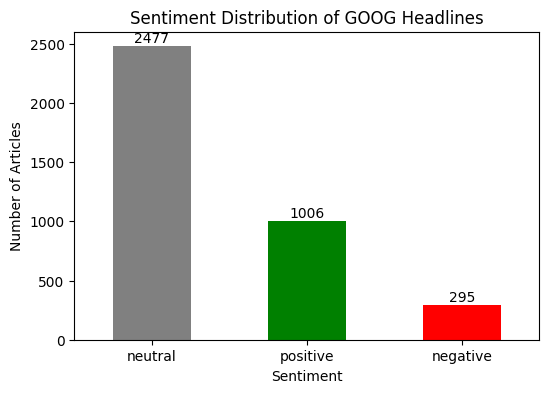

In [76]:
plot_sentiment(sentiment_counts, 'GOOG ')

Get META companies stock dataset

In [28]:
# Access the META dataset
meta_df = processed_data["META"]

# Display the first 5 rows of the META dataset
meta_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-12-12,28.000000,28.139999,27.370001,27.580000,27.523441,46704200
1,2012-12-13,27.590000,28.750000,27.430000,28.240000,28.182087,81051600
2,2012-12-14,28.180000,28.330000,26.760000,26.809999,26.755020,91631600
3,2012-12-17,26.770000,27.000000,26.320000,26.750000,26.695143,57742500
4,2012-12-18,26.959999,27.910000,26.900000,27.709999,27.653173,60512900


In [29]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2926 entries, 0 to 2925
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2926 non-null   datetime64[ns]
 1   Open       2926 non-null   float64       
 2   High       2926 non-null   float64       
 3   Low        2926 non-null   float64       
 4   Close      2926 non-null   float64       
 5   Adj Close  2926 non-null   float64       
 6   Volume     2926 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 160.1 KB


In [30]:
meta_df['Date'] = pd.to_datetime(meta_df['Date'], errors='coerce')

# Set 'Date' as the index
meta_df.set_index('Date', inplace=True)

In [32]:
meta_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-12-12,28.000000,28.139999,27.370001,27.580000,27.523441,46704200
2012-12-13,27.590000,28.750000,27.430000,28.240000,28.182087,81051600
2012-12-14,28.180000,28.330000,26.760000,26.809999,26.755020,91631600
2012-12-17,26.770000,27.000000,26.320000,26.750000,26.695143,57742500
2012-12-18,26.959999,27.910000,26.900000,27.709999,27.653173,60512900


Merge META with rating dataset

In [33]:
meta_merged_data = pd.merge(text_data, meta_df, left_on='Date', right_index=True, how='inner')

In [34]:
meta_merged_data.head()

,headline,url,publisher,stock,time,hour,minute,year,month,day,day_of_week,headlineClean,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,
2020-06-05,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,A,10:30:54,10,30,2020,6,5,Friday,stock hit week,226.710007,231.350006,225.309998,230.770004,230.296753,16750400
2020-06-03,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,A,10:45:20,10,45,2020,6,3,Wednesday,stock hit week,232.110001,232.649994,228.529999,230.160004,229.688019,15380300
2020-05-26,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,A,04:30:07,4,30,2020,5,26,Tuesday,biggest,239.770004,240.899994,231.669998,232.199997,231.723816,33178300
2020-05-22,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,A,12:45:06,12,45,2020,5,22,Friday,stock moving midday session,231.509995,235.990005,228.740005,234.910004,234.428268,33925600
2020-05-22,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,A,11:38:59,11,38,2020,5,22,Friday,neutral price target,231.509995,235.990005,228.740005,234.910004,234.428268,33925600


In [35]:
# Filter rows where 'headline' contains "META"
meta_related_data = meta_merged_data[meta_merged_data['headline'].str.contains("META", case=False, na=False)]

# Display the filtered DataFrame
meta_related_data

,headline,url,publisher,stock,time,hour,minute,year,month,day,day_of_week,headlineClean,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,
2020-05-14,"Alcoa CEO, Currently Presenting At BMO Global ...",https://www.benzinga.com/news/20/05/16032673/a...,Benzinga Newsdesk,AA,00:00:00,0,0,2020,5,14,Thursday,currently global mining conference could even ...,202.559998,206.929993,200.690002,206.809998,206.385895,17178900
2019-05-03,Shares of several consumer metals and mining c...,https://www.benzinga.com/markets/wiim/19/05/13...,Benzinga Newsdesk,AA,00:00:00,0,0,2019,5,3,Friday,several consumer mining trading higher commodi...,194.380005,196.160004,193.710007,195.470001,195.069153,14575400
2019-04-17,Alcoa To Report Q1 Earnings After The Closing ...,https://www.benzinga.com/news/earnings/19/04/1...,Benzinga Newsdesk,AA,00:00:00,0,0,2019,4,17,Wednesday,report earnings bell historically report payin...,179.600006,180.740005,178.360001,178.779999,178.413376,9973700
2018-04-23,"Watching Stock Futures Largely Unaffected, But...",https://www.benzinga.com/news/18/04/11556874/w...,Paul Quintaro,AA,00:00:00,0,0,2018,4,23,Monday,watching stock largely unaffected trading lowe...,167.270004,168.449997,165.089996,165.839996,165.499908,23088100
2018-04-06,"Watch Shares Of Century Aluminum, Alcoa, Arcon...",https://www.benzinga.com/trading-ideas/movers/...,Eddie Staley,AA,00:00:00,0,0,2018,4,6,Friday,watch century aluminum commercial kaiser alumi...,157.729996,161.419998,156.809998,157.199997,156.877625,41644800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-30,Zafgen Granted Orphan Drug Designation in the ...,https://www.benzinga.com/news/15/09/5875608/za...,Paul Quintaro,ZFGN,00:00:00,0,0,2015,9,30,Wednesday,orphan drug designation union inhibitor treatment,88.440002,90.019997,88.010002,89.900002,89.715637,36169100
2015-12-10,ZIOPHARM Reports Presentation of Phase 1b/2 St...,https://www.benzinga.com/news/15/12/6036319/zi...,Hal Lindon,ZIOP,00:00:00,0,0,2015,12,10,Thursday,presentation phase study gene therapy locally ...,105.050003,106.400002,104.410004,105.419998,105.203812,17454300
2015-04-27,ZIOPHARM Begins Phase 1b/2 Study of Ad-RTS-hIL...,https://www.benzinga.com/news/15/04/5444728/zi...,Hal Lindon,ZIOP,00:00:00,0,0,2015,4,27,Monday,phase study gene therapy locally advanced meta...,81.870003,82.930000,81.629997,81.910004,81.742027,25446000


In [36]:
sentiment_analysis_parallel(meta_related_data, 'headlineClean')

[('neutral', 0.0), ('positive', 0.125), ('neutral', 0.0), ('negative', -0.016666666666666666), ('neutral', 0.0)]


,headline,url,publisher,stock,time,hour,minute,year,month,day,day_of_week,headlineClean,Open,High,Low,Close,Adj Close,Volume,sentiment,polarity
Date,,,,,,,,,,,,,,,,,,,,
2020-05-14,"Alcoa CEO, Currently Presenting At BMO Global ...",https://www.benzinga.com/news/20/05/16032673/a...,Benzinga Newsdesk,AA,00:00:00,0,0,2020,5,14,Thursday,currently global mining conference could even ...,202.559998,206.929993,200.690002,206.809998,206.385895,17178900,neutral,0.000000
2019-05-03,Shares of several consumer metals and mining c...,https://www.benzinga.com/markets/wiim/19/05/13...,Benzinga Newsdesk,AA,00:00:00,0,0,2019,5,3,Friday,several consumer mining trading higher commodi...,194.380005,196.160004,193.710007,195.470001,195.069153,14575400,positive,0.125000
2019-04-17,Alcoa To Report Q1 Earnings After The Closing ...,https://www.benzinga.com/news/earnings/19/04/1...,Benzinga Newsdesk,AA,00:00:00,0,0,2019,4,17,Wednesday,report earnings bell historically report payin...,179.600006,180.740005,178.360001,178.779999,178.413376,9973700,neutral,0.000000
2018-04-23,"Watching Stock Futures Largely Unaffected, But...",https://www.benzinga.com/news/18/04/11556874/w...,Paul Quintaro,AA,00:00:00,0,0,2018,4,23,Monday,watching stock largely unaffected trading lowe...,167.270004,168.449997,165.089996,165.839996,165.499908,23088100,negative,-0.016667
2018-04-06,"Watch Shares Of Century Aluminum, Alcoa, Arcon...",https://www.benzinga.com/trading-ideas/movers/...,Eddie Staley,AA,00:00:00,0,0,2018,4,6,Friday,watch century aluminum commercial kaiser alumi...,157.729996,161.419998,156.809998,157.199997,156.877625,41644800,neutral,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-30,Zafgen Granted Orphan Drug Designation in the ...,https://www.benzinga.com/news/15/09/5875608/za...,Paul Quintaro,ZFGN,00:00:00,0,0,2015,9,30,Wednesday,orphan drug designation union inhibitor treatment,88.440002,90.019997,88.010002,89.900002,89.715637,36169100,neutral,0.000000
2015-12-10,ZIOPHARM Reports Presentation of Phase 1b/2 St...,https://www.benzinga.com/news/15/12/6036319/zi...,Hal Lindon,ZIOP,00:00:00,0,0,2015,12,10,Thursday,presentation phase study gene therapy locally ...,105.050003,106.400002,104.410004,105.419998,105.203812,17454300,positive,0.400000
2015-04-27,ZIOPHARM Begins Phase 1b/2 Study of Ad-RTS-hIL...,https://www.benzinga.com/news/15/04/5444728/zi...,Hal Lindon,ZIOP,00:00:00,0,0,2015,4,27,Monday,phase study gene therapy locally advanced meta...,81.870003,82.930000,81.629997,81.910004,81.742027,25446000,positive,0.400000


In [37]:
sentiment_counts = meta_related_data['sentiment'].value_counts()

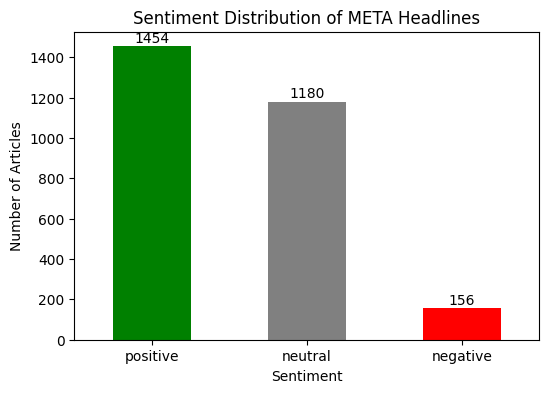

In [38]:
plot_sentiment(sentiment_counts, 'META ')

Get MICROSOFT companies stock dataset

In [40]:
# Access the MSFT dataset
msft_df = processed_data["MSFT"]

# Display the first 5 rows of the MSFT dataset
msft_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.059946,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062087,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063158,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061552,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060482,47894400


In [41]:
msft_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9672 entries, 0 to 9671
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       9672 non-null   datetime64[ns]
 1   Open       9672 non-null   float64       
 2   High       9672 non-null   float64       
 3   Low        9672 non-null   float64       
 4   Close      9672 non-null   float64       
 5   Adj Close  9672 non-null   float64       
 6   Volume     9672 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 529.1 KB


In [42]:
msft_df['Date'] = pd.to_datetime(msft_df['Date'], errors='coerce')

# Set 'Date' as the index
msft_df.set_index('Date', inplace=True)

In [43]:
msft_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.059946,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062087,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063158,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061552,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060482,47894400


Merge MSFT with rating dataset

In [44]:
msft_merged_data = pd.merge(text_data, msft_df, left_on='Date', right_index=True, how='inner')

In [45]:
msft_merged_data.head()

,headline,url,publisher,stock,time,hour,minute,year,month,day,day_of_week,headlineClean,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,
2020-06-05,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,A,10:30:54,10,30,2020,6,5,Friday,stock hit week,182.619995,187.729996,182.009995,187.199997,180.403564,39893600
2020-06-03,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,A,10:45:20,10,45,2020,6,3,Wednesday,stock hit week,184.820007,185.940002,183.580002,185.360001,178.630417,27311000
2020-05-26,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,A,04:30:07,4,30,2020,5,26,Tuesday,biggest,186.339996,186.500000,181.100006,181.570007,174.977966,36073600
2020-05-22,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,A,12:45:06,12,45,2020,5,22,Friday,stock moving midday session,183.190002,184.460007,182.539993,183.509995,176.847519,20826900
2020-05-22,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,A,11:38:59,11,38,2020,5,22,Friday,neutral price target,183.190002,184.460007,182.539993,183.509995,176.847519,20826900


In [46]:
# Filter rows where 'headline' contains "MSFT"
msft_related_data = msft_merged_data[msft_merged_data['headline'].str.contains("MSFT", case=False, na=False)]

# Display the filtered DataFrame
msft_related_data

,headline,url,publisher,stock,time,hour,minute,year,month,day,day_of_week,headlineClean,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,
2010-10-29,"Friday's Mid-Day Options Volume Leaders (MSFT,...",https://www.benzinga.com/market-update/10/10/5...,Michael J. Zerinskas,AA,00:00:00,0,0,2010,10,29,Friday,midday volume bac,27.150000,27.200001,26.480000,26.670000,20.412271,114193200
2010-10-19,"Dow Falls Below 11,000 (DJIA, BAC, IBM, AA, MSFT)",https://www.benzinga.com/general/10/10/533427/...,Swing Trader,AA,00:00:00,0,0,2010,10,19,Tuesday,dow bac,25.270000,25.370001,24.950001,25.100000,19.210653,66150900
2010-07-12,"Monday’s Mid-Day Options Volume Leaders (C, BP...",https://www.benzinga.com/market-update/10/07/3...,Michael J. Zerinskas,AA,00:00:00,0,0,2010,7,12,Monday,midday volume spy,24.430000,24.889999,24.420000,24.830000,18.903164,49854200
2010-06-01,"Beaten-Down Blue Chips A Good Buy? (MSFT, CSCO...",https://www.benzinga.com/general/10/06/308825/...,Swing Trader,AA,00:00:00,0,0,2010,6,1,Tuesday,blue chip good buy,25.530001,26.309999,25.520000,25.889999,19.710142,76152400
2010-03-31,"The Dow Dogs Of Q1 (AA, T, VZ, PFE, MSFT)",https://www.benzinga.com/general/202465/the-do...,Swing Trader,AA,00:00:00,0,0,2010,3,31,Wednesday,dow dog,29.639999,29.719999,29.170000,29.290001,22.198418,63760000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-29,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",https://www.benzinga.com/pre-market-outlook/20...,Benzinga Newsdesk,YUM,00:00:00,0,0,2020,1,29,Wednesday,top stock watch wed,167.839996,168.750000,165.690002,168.039993,161.049500,34754500
2010-02-03,"Mad Money Lightning Round: Jim Prefers MRK, SY...",https://www.benzinga.com/media/cnbc/109830/mad...,Monica Gerson,ZMH,00:00:00,0,0,2010,2,3,Wednesday,mad money lightning round mot,28.260000,28.790001,28.120001,28.629999,21.597210,61397900
2013-07-11,Tech Stocks Are Paying Record Dividends - But ...,https://www.benzinga.com/news/earnings/13/07/3...,Tim Parker,ZNGA,00:00:00,0,0,2013,7,11,Thursday,tech stock paying record still sexy dell,35.000000,35.770000,34.900002,35.689999,29.457098,53638300


In [47]:
sentiment_analysis_parallel(msft_related_data, 'headlineClean')

[('neutral', 0.0), ('neutral', 0.0), ('neutral', 0.0), ('positive', 0.35), ('neutral', 0.0)]


,headline,url,publisher,stock,time,hour,minute,year,month,day,day_of_week,headlineClean,Open,High,Low,Close,Adj Close,Volume,sentiment,polarity
Date,,,,,,,,,,,,,,,,,,,,
2010-10-29,"Friday's Mid-Day Options Volume Leaders (MSFT,...",https://www.benzinga.com/market-update/10/10/5...,Michael J. Zerinskas,AA,00:00:00,0,0,2010,10,29,Friday,midday volume bac,27.150000,27.200001,26.480000,26.670000,20.412271,114193200,neutral,0.0000
2010-10-19,"Dow Falls Below 11,000 (DJIA, BAC, IBM, AA, MSFT)",https://www.benzinga.com/general/10/10/533427/...,Swing Trader,AA,00:00:00,0,0,2010,10,19,Tuesday,dow bac,25.270000,25.370001,24.950001,25.100000,19.210653,66150900,neutral,0.0000
2010-07-12,"Monday’s Mid-Day Options Volume Leaders (C, BP...",https://www.benzinga.com/market-update/10/07/3...,Michael J. Zerinskas,AA,00:00:00,0,0,2010,7,12,Monday,midday volume spy,24.430000,24.889999,24.420000,24.830000,18.903164,49854200,neutral,0.0000
2010-06-01,"Beaten-Down Blue Chips A Good Buy? (MSFT, CSCO...",https://www.benzinga.com/general/10/06/308825/...,Swing Trader,AA,00:00:00,0,0,2010,6,1,Tuesday,blue chip good buy,25.530001,26.309999,25.520000,25.889999,19.710142,76152400,positive,0.3500
2010-03-31,"The Dow Dogs Of Q1 (AA, T, VZ, PFE, MSFT)",https://www.benzinga.com/general/202465/the-do...,Swing Trader,AA,00:00:00,0,0,2010,3,31,Wednesday,dow dog,29.639999,29.719999,29.170000,29.290001,22.198418,63760000,neutral,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-29,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",https://www.benzinga.com/pre-market-outlook/20...,Benzinga Newsdesk,YUM,00:00:00,0,0,2020,1,29,Wednesday,top stock watch wed,167.839996,168.750000,165.690002,168.039993,161.049500,34754500,positive,0.5000
2010-02-03,"Mad Money Lightning Round: Jim Prefers MRK, SY...",https://www.benzinga.com/media/cnbc/109830/mad...,Monica Gerson,ZMH,00:00:00,0,0,2010,2,3,Wednesday,mad money lightning round mot,28.260000,28.790001,28.120001,28.629999,21.597210,61397900,negative,-0.4125
2013-07-11,Tech Stocks Are Paying Record Dividends - But ...,https://www.benzinga.com/news/earnings/13/07/3...,Tim Parker,ZNGA,00:00:00,0,0,2013,7,11,Thursday,tech stock paying record still sexy dell,35.000000,35.770000,34.900002,35.689999,29.457098,53638300,positive,0.5000


In [48]:
sentiment_counts = msft_related_data['sentiment'].value_counts()

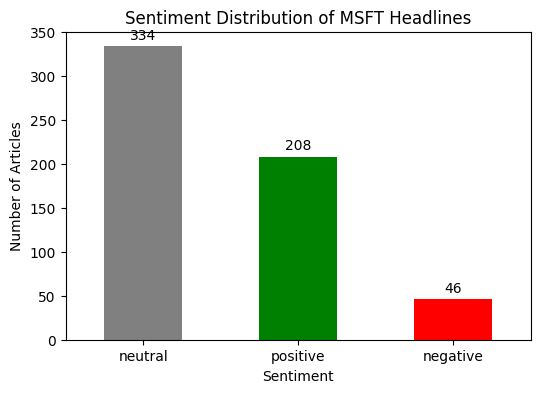

In [49]:
plot_sentiment(sentiment_counts, 'MSFT ')

Get NVIDIA companies stock dataset

In [71]:
# Access the MSFT dataset
nvda_df = processed_data["NVDA"]

# Display the first 5 rows of the NVDA dataset
nvda_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.043750,0.048828,0.038802,0.041016,0.037621,2714688000
1999-01-25,0.044271,0.045833,0.041016,0.045313,0.041562,510480000
1999-01-26,0.045833,0.046745,0.041146,0.041797,0.038337,343200000
1999-01-27,0.041927,0.042969,0.039583,0.041667,0.038218,244368000
1999-01-28,0.041667,0.041927,0.041276,0.041536,0.038098,227520000


In [72]:
nvda_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6421 entries, 1999-01-22 to 2024-07-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6421 non-null   float64
 1   High       6421 non-null   float64
 2   Low        6421 non-null   float64
 3   Close      6421 non-null   float64
 4   Adj Close  6421 non-null   float64
 5   Volume     6421 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 351.1 KB


In [ ]:
nvda_df['Date'] = pd.to_datetime(nvda_df['Date'], errors='coerce')

# Set 'Date' as the index
nvda_df.set_index('Date', inplace=True)

In [75]:
nvda_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.043750,0.048828,0.038802,0.041016,0.037621,2714688000
1999-01-25,0.044271,0.045833,0.041016,0.045313,0.041562,510480000
1999-01-26,0.045833,0.046745,0.041146,0.041797,0.038337,343200000
1999-01-27,0.041927,0.042969,0.039583,0.041667,0.038218,244368000
1999-01-28,0.041667,0.041927,0.041276,0.041536,0.038098,227520000


Merge NVDA with rating dataset

In [76]:
nvda_merged_data = pd.merge(text_data, nvda_df, left_on='Date', right_index=True, how='inner')

In [77]:
nvda_merged_data.head()

,headline,url,publisher,stock,time,hour,minute,year,month,day,day_of_week,headlineClean,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,
2020-06-05,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,A,10:30:54,10,30,2020,6,5,Friday,stock hit week,8.79450,8.99700,8.70800,8.92000,8.893502,481748000
2020-06-03,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,A,10:45:20,10,45,2020,6,3,Wednesday,stock hit week,8.82225,8.86625,8.70000,8.76950,8.739462,365440000
2020-05-26,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,A,04:30:07,4,30,2020,5,26,Tuesday,biggest,9.15675,9.18175,8.67200,8.71775,8.687888,770780000
2020-05-22,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,A,12:45:06,12,45,2020,5,22,Friday,stock moving midday session,8.82525,9.09300,8.71325,9.02625,8.995332,1038764000
2020-05-22,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,A,11:38:59,11,38,2020,5,22,Friday,neutral price target,8.82525,9.09300,8.71325,9.02625,8.995332,1038764000


In [78]:
# Filter rows where 'headline' contains "NVDA"
nvda_related_data = nvda_merged_data[nvda_merged_data['headline'].str.contains("NVDA", case=False, na=False)]

# Display the filtered DataFrame
nvda_related_data

,headline,url,publisher,stock,time,hour,minute,year,month,day,day_of_week,headlineClean,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,
2011-05-13,Top day traders Stocks and nalyst Upgrades & D...,https://www.benzinga.com/11/05/1082437/top-day...,CEO World,A,00:00:00,0,0,2011,5,13,Friday,top day stock,0.48000,0.48125,0.45300,0.45650,0.418714,2025192000
2011-05-12,"Stocks To Watch For May 13 (A, JWN, NVDA, YUM,...",https://www.benzinga.com/news/earnings/11/05/1...,Lisa Levin,A,00:00:00,0,0,2011,5,12,Thursday,stock watch may,0.49500,0.51300,0.49375,0.51250,0.470079,1224000000
2010-11-12,"Stocks To Watch For November 12 (CPKI, A, DIS,...",https://www.benzinga.com/market-update/10/11/6...,Monica Gerson,A,00:00:00,0,0,2010,11,12,Friday,stock watch dis,0.32725,0.34200,0.32575,0.33150,0.304061,2142560000
2011-01-11,"Tuesday's Mid-Day Options Volume Leaders (BAC,...",https://www.benzinga.com/options/11/01/770225/...,Michael J. Zerinskas,AA,00:00:00,0,0,2011,1,11,Tuesday,midday volume bac,0.52275,0.52775,0.49675,0.50775,0.465722,2711088000
2011-01-11,"Benzinga's Top Downgrades (AA, AYI, AMR, NVDA)",https://www.benzinga.com/analyst-ratings/downg...,Monica Gerson,AA,00:00:00,0,0,2011,1,11,Tuesday,top,0.52275,0.52775,0.49675,0.50775,0.465722,2711088000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-07-27,"Benzinga’s Top Pre-Market NASDAQ Losers (MNTA,...",https://www.benzinga.com/markets/company-news/...,Monica Gerson,WERN,00:00:00,0,0,2010,7,27,Tuesday,top,0.26450,0.26500,0.25825,0.26150,0.239855,683472000
2011-03-08,"Benzinga's Top Upgrades (NVDA, ANF, MIPS, WFT)",https://www.benzinga.com/analyst-ratings/upgra...,Lisa Levin,WFT,00:00:00,0,0,2011,3,8,Tuesday,top,0.51725,0.52000,0.47800,0.48875,0.448295,1947184000
2017-06-09,"Shorts Attack NVDA, TSLA and RLGT",https://www.benzinga.com/17/06/9592104/shorts-...,Zacks,WIX,00:00:00,0,0,2017,6,9,Friday,short attack,4.11850,4.21250,3.56875,3.74000,3.694325,3692928000


In [79]:
sentiment_analysis_parallel(nvda_related_data, 'headlineClean')

[('positive', 0.5), ('neutral', 0.0), ('neutral', 0.0), ('neutral', 0.0), ('positive', 0.5)]


,headline,url,publisher,stock,time,hour,minute,year,month,day,day_of_week,headlineClean,Open,High,Low,Close,Adj Close,Volume,sentiment,polarity
Date,,,,,,,,,,,,,,,,,,,,
2011-05-13,Top day traders Stocks and nalyst Upgrades & D...,https://www.benzinga.com/11/05/1082437/top-day...,CEO World,A,00:00:00,0,0,2011,5,13,Friday,top day stock,0.48000,0.48125,0.45300,0.45650,0.418714,2025192000,positive,0.5
2011-05-12,"Stocks To Watch For May 13 (A, JWN, NVDA, YUM,...",https://www.benzinga.com/news/earnings/11/05/1...,Lisa Levin,A,00:00:00,0,0,2011,5,12,Thursday,stock watch may,0.49500,0.51300,0.49375,0.51250,0.470079,1224000000,neutral,0.0
2010-11-12,"Stocks To Watch For November 12 (CPKI, A, DIS,...",https://www.benzinga.com/market-update/10/11/6...,Monica Gerson,A,00:00:00,0,0,2010,11,12,Friday,stock watch dis,0.32725,0.34200,0.32575,0.33150,0.304061,2142560000,neutral,0.0
2011-01-11,"Tuesday's Mid-Day Options Volume Leaders (BAC,...",https://www.benzinga.com/options/11/01/770225/...,Michael J. Zerinskas,AA,00:00:00,0,0,2011,1,11,Tuesday,midday volume bac,0.52275,0.52775,0.49675,0.50775,0.465722,2711088000,neutral,0.0
2011-01-11,"Benzinga's Top Downgrades (AA, AYI, AMR, NVDA)",https://www.benzinga.com/analyst-ratings/downg...,Monica Gerson,AA,00:00:00,0,0,2011,1,11,Tuesday,top,0.52275,0.52775,0.49675,0.50775,0.465722,2711088000,positive,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-07-27,"Benzinga’s Top Pre-Market NASDAQ Losers (MNTA,...",https://www.benzinga.com/markets/company-news/...,Monica Gerson,WERN,00:00:00,0,0,2010,7,27,Tuesday,top,0.26450,0.26500,0.25825,0.26150,0.239855,683472000,positive,0.5
2011-03-08,"Benzinga's Top Upgrades (NVDA, ANF, MIPS, WFT)",https://www.benzinga.com/analyst-ratings/upgra...,Lisa Levin,WFT,00:00:00,0,0,2011,3,8,Tuesday,top,0.51725,0.52000,0.47800,0.48875,0.448295,1947184000,positive,0.5
2017-06-09,"Shorts Attack NVDA, TSLA and RLGT",https://www.benzinga.com/17/06/9592104/shorts-...,Zacks,WIX,00:00:00,0,0,2017,6,9,Friday,short attack,4.11850,4.21250,3.56875,3.74000,3.694325,3692928000,neutral,0.0


In [80]:
sentiment_counts = nvda_related_data['sentiment'].value_counts()

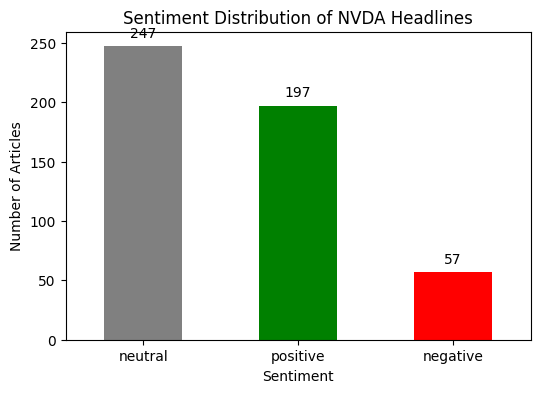

In [81]:
plot_sentiment(sentiment_counts, 'NVDA ')

Get TESLA companies stock dataset

In [82]:
# Access the TSLA dataset
tsla_df = processed_data["TSLA"]

# Display the first 5 rows of the TSLA dataset
tsla_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [83]:
tsla_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3545 entries, 2010-06-29 to 2024-07-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3545 non-null   float64
 1   High       3545 non-null   float64
 2   Low        3545 non-null   float64
 3   Close      3545 non-null   float64
 4   Adj Close  3545 non-null   float64
 5   Volume     3545 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 193.9 KB


In [62]:
tsla_df['Date'] = pd.to_datetime(tsla_df['Date'], errors='coerce')

# Set 'Date' as the index
tsla_df.set_index('Date', inplace=True)

In [84]:
tsla_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


Merge TSLA with rating dataset

In [85]:
tsla_merged_data = pd.merge(text_data, tsla_df, left_on='Date', right_index=True, how='inner')

In [86]:
tsla_merged_data.head()

,headline,url,publisher,stock,time,hour,minute,year,month,day,day_of_week,headlineClean,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,
2020-06-05,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,A,10:30:54,10,30,2020,6,5,Friday,stock hit week,58.522667,59.101334,57.746666,59.043999,59.043999,117178500
2020-06-03,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,A,10:45:20,10,45,2020,6,3,Wednesday,stock hit week,59.208000,59.862667,58.673332,58.863998,58.863998,119242500
2020-05-26,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,A,04:30:07,4,30,2020,5,26,Tuesday,biggest,55.633331,55.639999,54.380669,54.591331,54.591331,121345500
2020-05-22,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,A,12:45:06,12,45,2020,5,22,Friday,stock moving midday session,54.811333,55.452000,54.133331,54.458668,54.458668,149812500
2020-05-22,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,A,11:38:59,11,38,2020,5,22,Friday,neutral price target,54.811333,55.452000,54.133331,54.458668,54.458668,149812500


In [87]:
# Filter rows where 'headline' contains "TSLA"
tsla_related_data = tsla_merged_data[tsla_merged_data['headline'].str.contains("TSLA", case=False, na=False)]

# Display the filtered DataFrame
tsla_related_data

,headline,url,publisher,stock,time,hour,minute,year,month,day,day_of_week,headlineClean,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,
2015-12-29,UBS Says 5 Most Shorted Stocks On Monday Were ...,https://www.benzinga.com/analyst-ratings/analy...,Paul Quintaro,AA,00:00:00,0,0,2015,12,29,Tuesday,stock cat baba according client concentration,15.337333,15.848000,15.303333,15.812667,15.812667,36094500
2011-05-04,"Earnings Scheduled For May 4 (PCG, WFMI, TWX, ...",https://www.benzinga.com/news/earnings/11/05/1...,Lisa Levin,ACE,00:00:00,0,0,2011,5,4,Wednesday,earnings may bud met rig ace,1.785333,1.800000,1.716667,1.779333,1.779333,15667500
2019-12-24,Benzinga Pro's Top 5 Stocks To Watch For Tues....,https://www.benzinga.com/pre-market-outlook/19...,Benzinga Newsdesk,ACST,00:00:00,0,0,2019,12,24,Tuesday,top stock watch,27.890667,28.364668,27.512667,28.350000,28.350000,120820500
2011-03-31,"Benzinga's Volume Movers (TSLA, DNDN, ACXM, MAKO)",https://www.benzinga.com/news/11/03/966878/ben...,Monica Gerson,ACXM,00:00:00,0,0,2011,3,31,Thursday,volume mako,1.770000,1.914000,1.766667,1.850000,1.850000,172767000
2013-07-10,What to Expect From Tesla Shares After Joining...,https://www.benzinga.com/trading-ideas/long-id...,ETF Professor,ADI,00:00:00,0,0,2013,7,10,Wednesday,expect joining,8.212667,8.216667,8.052667,8.151333,8.151333,84001500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-03,"Benzinga Pro's Top 5 Stocks To Watch For Fri.,...",https://www.benzinga.com/pre-market-outlook/20...,Benzinga Newsdesk,YUMA,00:00:00,0,0,2020,1,3,Friday,top stock watch axe,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2013-10-09,These Four Story Stocks Got Beat Up Tuesday (T...,https://www.benzinga.com/news/13/10/3976910/th...,Tim Parker,ZNGA,00:00:00,0,0,2013,10,9,Wednesday,four story stock got beat,11.648667,11.666000,10.766667,11.252000,11.252000,229747500
2014-02-25,"Morning Movers for Feb. 25, 2014: IMUC, MSO, Z...",https://www.benzinga.com/news/14/02/4341590/mo...,Paul Quintaro,ZU,00:00:00,0,0,2014,2,25,Tuesday,morning moving higher lower,15.333333,17.280001,15.230000,16.533333,16.533333,490225500


In [88]:
sentiment_analysis_parallel(tsla_related_data, 'headlineClean')

[('neutral', 0.0), ('neutral', 0.0), ('positive', 0.5), ('neutral', 0.0), ('neutral', 0.0)]


,headline,url,publisher,stock,time,hour,minute,year,month,day,day_of_week,headlineClean,Open,High,Low,Close,Adj Close,Volume,sentiment,polarity
Date,,,,,,,,,,,,,,,,,,,,
2015-12-29,UBS Says 5 Most Shorted Stocks On Monday Were ...,https://www.benzinga.com/analyst-ratings/analy...,Paul Quintaro,AA,00:00:00,0,0,2015,12,29,Tuesday,stock cat baba according client concentration,15.337333,15.848000,15.303333,15.812667,15.812667,36094500,neutral,0.00
2011-05-04,"Earnings Scheduled For May 4 (PCG, WFMI, TWX, ...",https://www.benzinga.com/news/earnings/11/05/1...,Lisa Levin,ACE,00:00:00,0,0,2011,5,4,Wednesday,earnings may bud met rig ace,1.785333,1.800000,1.716667,1.779333,1.779333,15667500,neutral,0.00
2019-12-24,Benzinga Pro's Top 5 Stocks To Watch For Tues....,https://www.benzinga.com/pre-market-outlook/19...,Benzinga Newsdesk,ACST,00:00:00,0,0,2019,12,24,Tuesday,top stock watch,27.890667,28.364668,27.512667,28.350000,28.350000,120820500,positive,0.50
2011-03-31,"Benzinga's Volume Movers (TSLA, DNDN, ACXM, MAKO)",https://www.benzinga.com/news/11/03/966878/ben...,Monica Gerson,ACXM,00:00:00,0,0,2011,3,31,Thursday,volume mako,1.770000,1.914000,1.766667,1.850000,1.850000,172767000,neutral,0.00
2013-07-10,What to Expect From Tesla Shares After Joining...,https://www.benzinga.com/trading-ideas/long-id...,ETF Professor,ADI,00:00:00,0,0,2013,7,10,Wednesday,expect joining,8.212667,8.216667,8.052667,8.151333,8.151333,84001500,neutral,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-03,"Benzinga Pro's Top 5 Stocks To Watch For Fri.,...",https://www.benzinga.com/pre-market-outlook/20...,Benzinga Newsdesk,YUMA,00:00:00,0,0,2020,1,3,Friday,top stock watch axe,29.366667,30.266666,29.128000,29.534000,29.534000,266677500,positive,0.50
2013-10-09,These Four Story Stocks Got Beat Up Tuesday (T...,https://www.benzinga.com/news/13/10/3976910/th...,Tim Parker,ZNGA,00:00:00,0,0,2013,10,9,Wednesday,four story stock got beat,11.648667,11.666000,10.766667,11.252000,11.252000,229747500,neutral,0.00
2014-02-25,"Morning Movers for Feb. 25, 2014: IMUC, MSO, Z...",https://www.benzinga.com/news/14/02/4341590/mo...,Paul Quintaro,ZU,00:00:00,0,0,2014,2,25,Tuesday,morning moving higher lower,15.333333,17.280001,15.230000,16.533333,16.533333,490225500,positive,0.25


In [89]:
sentiment_counts = tsla_related_data['sentiment'].value_counts()

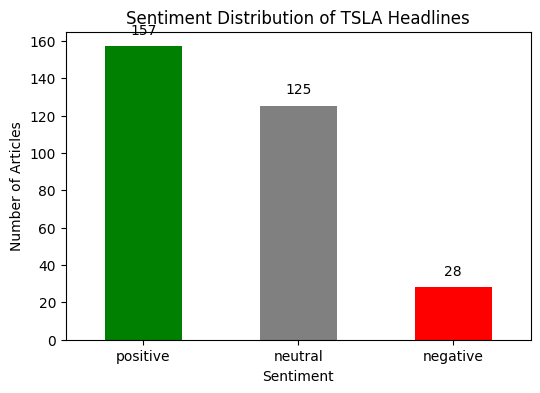

In [90]:
plot_sentiment(sentiment_counts, 'TSLA ')